In [1]:
import os,re
import shutil
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.pylab import mpl
import struct
import serial
from pathlib import Path

mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
g = 9.801538877

def move_dir(src,dest):
    if not os.path.exists(dest):
        os.makedirs(dest)
    shutil.move(src,dest)
def split_pro(data):
    split_symbol = [' ',',','，']
    for symbol in split_symbol:
        data = '#*#'.join(data.split(symbol))
    return [item for item in data.split('#*#') if item]

In [ ]:

def del_empty_folder(path):
    list_delFolder = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path,folder)
        if os.path.isdir(folder_path):
            del_empty_folder(folder_path)
            if not os.listdir(folder_path):
                os.rmdir(folder_path)
                list_delFolder.append(folder)
    return list_delFolder

def extract_number(filename):
    match = re.search(r'BD(\d+)#',filename)
    return int(match.group(1)) if match else float('inf')
def sort_bd_files(folder_path):
    files = os.listdir(folder_path)
    bd_files = [f for f in files if re.search(r'BD(\d+)#',f)]
    sorted_files = sorted(bd_files,key=extract_number)
    return sorted_files

def fun_lw_average(df,lw_skip,lw_list_sort,bd_skip,bd_list_sort,per=4,ga_shift=3):
    glw_list = []
    gbd_list = []
    alw_list = []
    abd_list = []
    aname_list = []
    fzj_list = []
    axis_name_list = ['x','y','z']
    all_ag_list = [glw_list,gbd_list,alw_list,abd_list]
    for item in all_ag_list:
        for i in range(3):
            item.append([])
    
    df.drop(df.columns[0],axis=1,inplace=True)

    for i in range(3):

        glw_mean = df.iloc[ i*per+lw_skip: (i+1)*per+lw_skip, lw_list_sort[i] ]
        alw_mean = df.iloc[ i*per+lw_skip: (i+1)*per+lw_skip, lw_list_sort[i]+ga_shift ]
        glw_list[lw_list_sort[i]].append(glw_mean.mean())
        alw_list[lw_list_sort[i]].append(alw_mean.mean())

        gbd_mean = df.iloc[ i*per+bd_skip: (i+1)*per+bd_skip, bd_list_sort[i] ]
        abd_mean = df.iloc[ i*per+bd_skip: (i+1)*per+bd_skip, bd_list_sort[i]+ga_shift ]
        gbd_list[bd_list_sort[i]].append( (gbd_mean[gbd_mean>0].mean()-gbd_mean[gbd_mean<0].mean())/2 )
        abd_list[bd_list_sort[i]].append( (abd_mean[abd_mean>0].mean()-abd_mean[abd_mean<0].mean())/2 )

    for i in range(3):
        if i==0:
            sqrt_gxyz = df.iloc[:,i]**2
            sqrt_axyz = df.iloc[:,i+ga_shift]**2
        else:
            sqrt_gxyz += df.iloc[:,i]**2
            sqrt_axyz += df.iloc[:,i+ga_shift]**2
    
    for i in range(3):
        for j in range(3):
            if i==j:
                continue
            t_name = axis_name_list[bd_list_sort[i]]
            o_name = axis_name_list[bd_list_sort[j]]
            aname = 'K{}{}'.format(o_name,t_name)
            aname_list.append(aname)
            zd_data = df.iloc[ i*per+bd_skip: (i+1)*per+bd_skip, bd_list_sort[i]+ga_shift ]
            cd_data = df.iloc[ i*per+bd_skip: (i+1)*per+bd_skip, bd_list_sort[j]+ga_shift ]
            fzj_data = (np.arcsin(cd_data/zd_data)/np.pi*180*60)[-6:].mean()
            fzj_list.append(fzj_data)

    sqrt_gxyz_mean = np.sqrt(sqrt_gxyz.mean())
    sqrt_axyz_mean = np.sqrt(sqrt_axyz.mean())
    return gbd_list,glw_list,abd_list,alw_list,sqrt_gxyz_mean,sqrt_axyz_mean,aname_list,fzj_list

def fun_sl_average(df,gsl_list_sort,sl_list,zf_list):
    all_sl_list = []
    bd_list = [[],[],[]]
    fxxd_list = [[],[],[]]
    gname_list = []
    fzj_list = []


    axis_name_list = ['x','y','z']
    for i in sl_list:
        for j in [1,-1]:
            all_sl_list.append(i*j)
    sl_point_length = len(all_sl_list)
    # print(all_sl_list)
    df.drop(df.columns[0],axis=1,inplace=True)

    for i in range(3):
        bd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[i] ] * zf_list[i] / 3600 
        # if i==0:
        #     print(list(bd_data))
        data_x = list(bd_data)
        data_y = all_sl_list
        fits = np.polyfit(data_y,data_x,1)
        # erros = data_x - data_y*fits[0]-fits[1]
        erros = [ data_x[i] - data_y[i]*fits[0]-fits[1] for i in range(len(data_x))]
        bd_list[gsl_list_sort[i]].append(fits[0])
        fxxd_list[gsl_list_sort[i]].append( float((pd.DataFrame(erros).abs().max()/fits[0]*1e6/180).iloc[0]) )
    for i in range(3):
        for j in range(3):
            if i==j:
                continue
            t_name = axis_name_list[gsl_list_sort[i]]
            o_name = axis_name_list[gsl_list_sort[j]]
            gname = 'K{}{}'.format( ,t_name)
            gname_list.append(gname)
            zd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[i] ] * zf_list[i]
            cd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[j] ] * zf_list[i]
            fzj_data = (np.arcsin(cd_data/zd_data)/np.pi*180*60)[-6:].mean()
            # print(np.arcsin(cd_data/zd_data)/np.pi*180*60)
            fzj_list.append(fzj_data)

    return bd_list, fxxd_list, gname_list, fzj_list


In [2]:
import pandas as pd
def init_sdf():
    # 初始化文件
    list_columns = [
        "G0", "G+", "G-", 
        "ScaleFactor+", "ScaleFactor-", "NonLinear", 
        "K*x", "K*y", "K*z", 
        "Temp"
    ]
    list_rows = ["Gx", "Gy", "Gz", "Ax", "Ay", "Az"]
    sdf = pd.DataFrame(0,index=list_rows, columns=list_columns)
    return sdf  
init_sdf()


,G0,G+,G-,ScaleFactor+,ScaleFactor-,NonLinear,K*x,K*y,K*z,Temp
Gx,0,0,0,0,0,0,0,0,0,0
Gy,0,0,0,0,0,0,0,0,0,0
Gz,0,0,0,0,0,0,0,0,0,0
Ax,0,0,0,0,0,0,0,0,0,0
Ay,0,0,0,0,0,0,0,0,0,0
Az,0,0,0,0,0,0,0,0,0,0


In [ ]:
class struct_paraCal:
    def __init__(self):
        self.init_list()
        self.init_conf()
        
    def init_list(self):
        # 初始化测试结果变量
        self.list_SL = []
        self.list_SL_FFZ = []
        self.list_BD_PPM = []
        self.list_LW = []
        self.list_LW_FFZ = []
        self.list_LW_PPM = []
        self.list_LW_STD = []
        self.list_JT = []
        self.list_JT_FFZ = []
        self.list_JT_Allan = []
        self.list_JT_10s = []
        self.list_JT_ns = []
        self.list_FXXD = []
        self.list_FXXD_FFZ = []
        self.list_FXXD_PPM = []
        self.list_FXXD_PPM = []
        self.list_FXXD_STD = []
        self.list_Kxn = []
        self.list_Kyn = []
        self.list_Kzn = []
        self.list_sqrt = []
        
    def init_conf(self):
        # 初始化全局变量
        # 当地属性
        self.longitude = 116.50271
        self.latitude = 39.73155
        self.G = 9.801538877
        # 标度因数相关
        self.SL_name = ['SL','s_average.txt']
        self.SL_sort = [1,2,0]
        self.SL_skipNum = 0
        self.SL_rShiftNum = 1
        # self.SL_point_count = [10,10,10]
        self.SL_point_list = [10,50,100,150,180]
        # self.SL_point_list = [10,50,90]
        self.SL_point_zf = [1,1,1]
        # 零位相关
        self.LW_name = ['LW','s_average.txt']
        self.LW_GxyzSkipNum = 0
        self.LW_GxyzSort = [0,2,1]
        self.LW_AxyzSkipNum = 4
        self.LW_AxyzSort = [1,0,2]
        self.LW_GAxyzPerCount = 4
        # 静态相关
        self.JT_name = ['JT','s_average.txt']
        self.JT_rolls_num = 1
        # 归一化处理 加速度单位：m/s^2；角速度单位：rad/s。 温度:℃
        self.num_GxyzShift = 1
        # self.Gxyz_paraMult = [0.092,0.092,0.092]
        self.Gxyz_paraMult = [1]*3
        self.num_AxyzShift = 4
        # self.Axyz_paraMult = [0.00126,0.00126,0.00126]
        self.Axyz_paraMult = [10]*10
        self.num_GxyzTempShift =[10,11,12]
        self.Gtemp_paraMult = [1,1,1]
        self.num_AxyzTempShift = [7,8,9]
        self.Atemp_paraMult = [1,1,1]
        self.num_saveDecimal = 6
        self.
        = 10
        # 配置内容
        self.list_showMsg = []
        self.list_debugMsg = []
        self.flag_delEmptyFolder = 1
        self.flag_saveSecondAverage = 1
        self.flag_saveHzAverage = 1
        self.flag_onlySaveXYZ = 1
        self.list_GAGtAt = [
            'Turntable',
            'Gx(deg/h)','Gy(deg/h)','Gz(deg/h)',
            'Ax(m/s2)','Ay(m/s2)','Az(m/s2)',
            'GxTemp','GyTemp','GzTemp',
            'AxTemp','AyTemp','AzTemp',
            'Length','Other'
            ]
        # 尽可能多的取整数圈
        self.num_remainderSL = 36
        self.num_remainderLW = 10
        self.num_remainderMax = 3000
        
    def load_BD_file(self,paths):
        try: self.processing_BD_file(paths,mode='ave')
        except Exception as e: self.list_showMsg.append('Exceprion [processing_BD_file]:{}'.format(e))
        try: self.processing_BD_file(paths,mode='std')
        except Exception as e: self.list_showMsg.append('Exception [processing_BD_file]:{}'.format(e))
        try: self.processing_BD_SL(paths)
        except Exception as e: self.list_showMsg.append('Exception [processing_BD_SL]:{}'.format(e))
        try: self.processing_BD_LW(paths)
        except Exception as e: self.list_showMsg.append('Exception [processing_BD_LW]:{}'.format(e))
        
    def processing_BD_ave(self,paths):
        try: self.processing_BD_file(paths,mode='ave')
        except Exception as e: self.list_showMsg.append('Exceprion [processing_BD_ave]:{}'.format(e))
    def processing_BD_std(self,paths):
        try: self.processing_BD_file(paths,mode='std')
        except Exception as e: self.list_showMsg.append('Exception [processing_BD_std]:{}'.format(e))
    def processing_BD_SL(self,paths):
        try: self.load_SL_file(paths)
        except Exception as e:self.list_showMsg.append('Exception [processing_BD_SL]:{}'.format(e))
    def processing_BD_LW(self,paths):
        try: self.load_LW_file(paths)
        except Exception as e:self.list_showMsg.append('Exception [processing_BD_LW]:{}'.format(e))
        
        
    # 查看全局变量
    def show_dict(self):
        for i in self.__dict__:
            if 'list' not in i:
                print('{}\t{}'.format(i,self.__dict__[i]))
        pass
    # 初始化变量列表 将数字转列表
    def get_all2List(self,lists=None):
        if isinstance(lists,list):
            init_num_list = lists
        else:
            return False
        for item_count in range(len(init_num_list)):
            item = init_num_list[item_count]
            if isinstance(item,int):
                init_num_list[item_count] = [item,item+1,item+2]
            elif isinstance(item,list):
                for i in range(3):
                    try:item[i]
                    except:init_num_list[item_count].append(item[i-1])
            else:
                print('格式错误:{}'.format(item))
        return init_num_list
        
    # 平均处理标定数据
    def processing_BD_file(self,paths,mode='ave'):
        load_paths = Path(paths)
        if mode=='ave':
            processMode = 'ave'
            std_num = ''
        elif mode=='std':
            processMode = 'std'
            std_num = 'roll{}s_'.format(self.JT_rolls_num)
        # 删除空文件夹
        if self.flag_delEmptyFolder:
            list_delFolder = del_empty_folder(load_paths)
            for msg in list_delFolder:
                self.list_showMsg.append('删除空文件夹: {}'.format(msg))
        # 删除均值缓存文件夹
        save_path = load_paths/('all_%s'%processMode)
        if os.path.exists(save_path):
            shutil.rmtree(save_path)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        print(os.listdir(load_paths))
        for plan_name in os.listdir(load_paths):
            if not os.path.isdir(load_paths/plan_name):
                continue
            if plan_name=='all_%s'%processMode:
                continue
            list_all_file = [f for f in os.listdir(load_paths/plan_name) if re.search(r'BD(\d+)#',f)]
            list_hzFile = [i for i in list_all_file if ('hz.txt' in i)]
            list_sFile = [i for i in list_all_file if ('s.txt' in i)]
            if list_hzFile :
                if self.flag_saveHzAverage:
                    save_file_hz = save_path/'{}_{}_{}hz.txt'.format(plan_name,processMode,std_num)
                    list_hzFile = sorted(list_hzFile,key=extract_number)
            if list_sFile :
                if self.flag_saveSecondAverage:
                    save_file_s = save_path/'{}_{}_{}s.txt'.format(plan_name,processMode,std_num)
                    list_sFile = sorted(list_sFile,key=extract_number)
                    
            for filename in list_hzFile+list_sFile:
                if 'hz.txt' in filename:
                    Hz = self.num_Hz
                    save_name = save_file_hz
                else: 
                    Hz = 1
                    save_name = save_file_s
                try:
                    files = pd.read_csv(load_paths/plan_name/filename,sep='\\s+',header=None,skiprows=1, encoding='gb2312')
                except:
                    self.list_showMsg.append('打开文件失败: {}',format(filename))
                    continue
                if ('spd[' in filename):
                    turn_table = filename.split('spd[')[1].split(']')[0]
                    mean_length = -self.num_remainderSL*Hz*(files.shape[0]//(self.num_remainderSL*Hz))
                elif ('loc[' in filename):
                    turn_table = filename.split('loc[')[1].split(']')[0]
                    mean_length = -self.num_remainderLW*Hz*(files.shape[0]//(self.num_remainderLW*Hz))
                else:
                    turn_table = 'None'
                    mean_length = None
                if abs(mean_length)<10:
                    mean_length = None
                if mean_length:
                    if self.num_remainderMax*Hz<-mean_length:   
                        mean_length = -self.num_remainderMax*Hz
                        
                        
                # 根据全局变量归一化处理数据
                init_num_list = [
                    self.num_GxyzShift,
                    self.num_AxyzShift,
                    self.num_GxyzTempShift,
                    self.num_AxyzTempShift
                ]
                init_num_list = self.get_all2List(init_num_list)
                init_para_list = [
                    self.Gxyz_paraMult,
                    self.Axyz_paraMult,
                    self.Gtemp_paraMult,
                    self.Atemp_paraMult
                ]
                init_para_list = self.get_all2List(init_para_list)
                # 仅保存陀螺加表及对应温度\
                if self.flag_onlySaveXYZ:
                    df = pd.DataFrame([])
                    for j in range(len(init_num_list)):
                        for i in range(3): 
                            df = pd.concat([ df,files.iloc[:,init_num_list[j][i]]*init_para_list[j][i] ],axis=1)
                # 全部保存
                else:
                    for j in range(len(init_num_list)):
                        for i in range(3):
                            files.iloc[:,init_num_list[j][i]] *= init_para_list[j][i]
                    df = files
                    
                # 根据文件长度构造新的列表
                files = df.iloc[mean_length:,:]
                if processMode=='ave':
                    processData = files.mean()
                if processMode=='std':
                    processData = files.mean()
                    for i in range(6):
                        processData.iloc[i] = files.iloc[:,i].rolling(self.JT_rolls_num).mean().std()
                    
                len_data = len(files)
                save_data_list = []
                save_data_list.append(str(turn_table))
                for i in range(len(processData)):
                    save_data_list.append('{:.{}f}'.format(processData.iloc[i],self.num_saveDecimal))
                save_data_list.append(str(len_data))
                
            
                if not os.path.exists(save_name):
                    with open(save_name,encoding='gb2312',mode='w') as f:
                        save_title_list = []
                        for i in range(len(save_data_list)):
                            try:
                                save_title_list.append(self.list_GAGtAt[i])
                            except:
                                save_title_list.append(self.list_GAGtAt[-1])
                        f.write('\t'.join(save_title_list)+'\n')
                with open(save_name,encoding='gb2312',mode='a+') as f:
                    f.write('\t'.join(save_data_list)+'\n')
    
        
        
    # 处理速率文件
    def load_SL_file(self,paths):
        save_path = '{}/{}'.format(paths,'all_para')
        load_path = '{}/{}'.format(paths,'all_ave')
        if not os.path.exists(load_path):
            self.list_showMsg.append('load_SL_file找不到文件夹: {}',format(load_path))
            return False
            
        # 删除速率缓存文件夹
        # if os.path.exists(save_path):
        #     shutil.rmtree(save_path)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_name = '{}/{}.txt'.format(save_path,'all_para_[SL,BD,FXXD,FZJ]')
        if os.path.exists(save_name):
            os.remove(save_name)
            
        init_num_list = [
            self.num_GxyzShift,
            self.num_AxyzShift,
            self.num_GxyzTempShift,
            self.num_AxyzTempShift
        ]
        init_num_list = self.get_all2List(init_num_list)
        save_title_list = [
            'fileName','GxScale','GyScale','GzScale',
            'GxNonLinear','GyNonLinear','GzNonLinear']
        temp_title_list = ['GxTemp','GyTemp','GzTemp']
        
        listdir = os.listdir(load_path)
        listStxt =[f for f in listdir if 's.txt' in f]
        listHztxt = [f for f in listdir if 'hz.txt' in f]
        if len(listStxt)>=len(listHztxt):
            listdir = listStxt
        else:
            listdir = listHztxt
        
        sorted_list = []
        left_list = []
        list_all_file = [f for f in listdir if re.search(self.SL_name[0],f.upper())]
        for name in list_all_file:
            split_name = name.split('_')
            index = split_name.index(self.SL_name[0])+1
            try:sorted_list.append(name) if int(split_name[index])&False else sorted_list.append(name)
            except:left_list.append(name)
        sorted_list = sorted(
            sorted_list,
            key=lambda item:int(item.split('_')[index])
            )
        sorted_list+= sorted(left_list)
        
        for name in sorted_list:
            try:
                df = pd.read_csv('{}/{}'.format(load_path,name),sep='\\s+',header=None,skiprows=1,encoding='gb2312')
            except:
                self.list_showMsg.append('load_SL_file打开文件失败: {}',format(name))
                continue
            bd_list, fxxd_list, gname_list, fzj_list = fun_sl_average(df,self.SL_sort,self.SL_point_list,self.SL_point_zf)
            GxyzTemp = df.iloc[:,init_num_list[2][0]:init_num_list[2][-1]+1].mean()
            if not os.path.exists(save_name):
                save_title_list+=gname_list+temp_title_list
                with open(save_name,encoding='gb2312',mode='w') as f:
                    f.write('\t'.join(save_title_list)+'\n')
            save_data_list = []
            save_data_list.append(name.replace('.txt',''))
            for i in range(len(bd_list)):
                save_data_list.append('{:.{}f}'.format(bd_list[i][0],self.num_saveDecimal))
            for i in range(len(fxxd_list)):
                save_data_list.append('{:.{}f}'.format(fxxd_list[i][0],self.num_saveDecimal))
            for i in range(len(fzj_list)):
                save_data_list.append('{:.{}f}'.format(fzj_list[i],self.num_saveDecimal))
            for i in range(len(GxyzTemp)):
                save_data_list.append('{:.{}f}'.format(GxyzTemp.iloc[i],self.num_saveDecimal))
            with open(save_name,encoding='gb2312',mode='a+') as f:
                f.write('\t'.join(save_data_list)+'\n')
            
    # 处理零位文件
    def load_LW_file(self,paths):
        save_path = '{}/{}'.format(paths,'all_para')
        load_path = '{}/{}'.format(paths,'all_ave')
        if not os.path.exists(load_path):
            self.list_showMsg.append('load_LW_file找不到文件夹: {}',format(load_path))
            return False
            
        # 删除速率缓存文件夹
        # if os.path.exists(save_path):
        #     shutil.rmtree(save_path)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_name = '{}/{}.txt'.format(save_path,'all_para_[LW,GAxyz,JT]')
        if os.path.exists(save_name):
            os.remove(save_name)
        
        init_num_list = [
            self.num_GxyzShift,
            self.num_AxyzShift,
            self.num_GxyzTempShift,
            self.num_AxyzTempShift
        ]
        init_num_list = self.get_all2List(init_num_list)
        save_title_list = [
            'fileName','Gx+g','Gy+g','Gz+g',
            'Gx0','Gy0','Gz0',
            'Ax+g','Ay+g','Az+g',
            'Ax0','Ay0','Az0']
        temp_title_list = ['AxTemp','AyTemp','AzTemp']
        
        
        listdir = os.listdir(load_path)
        listStxt =[f for f in listdir if 's.txt' in f]
        listHztxt = [f for f in listdir if 'hz.txt' in f]
        if len(listStxt)>=len(listHztxt):
            listdir = listStxt
        else:
            listdir = listHztxt
        sorted_list = []
        left_list = []
        list_all_file = [f for f in listdir if re.search(self.LW_name[0],f.upper())]
        for name in list_all_file:
            split_name = name.split('_')
            index = split_name.index(self.LW_name[0])+1
            try:sorted_list.append(name) if int(split_name[index])&False else sorted_list.append(name)
            except:left_list.append(name)
        sorted_list = sorted(
            sorted_list,
            key=lambda item:int(item.split('_')[index])
            )
        sorted_list+= sorted(left_list)
        # print(sorted_list)
        for name in sorted_list:
            print(name)
            try:
                df = pd.read_csv('{}/{}'.format(load_path,name),sep='\\s+',header=None,skiprows=1,encoding='gb2312')
            except:
                self.list_showMsg.append('load_LW_file打开文件失败: {}',format(name))
                continue
            # print(df.head(5))
            gbd_list,glw_list,abd_list,alw_list,sqrt_gxyz_mean,sqrt_axyz_mean,aname_list,fzj_list = fun_lw_average(
                df,
                self.LW_GxyzSkipNum,
                self.LW_GxyzSort,
                self.LW_AxyzSkipNum,
                self.LW_AxyzSort,
                self.LW_GAxyzPerCount
                )
            all_bdlw_list = [gbd_list,glw_list,abd_list,alw_list]
            # print(gbd_list)
            # print(df)
            # print(glw_list)
            # print(abd_list)
            # print(alw_list)
            # print(aname_list)
            # print(fzj_list)
            AxyzTemp = df.iloc[:,init_num_list[3][0]:init_num_list[3][-1]+1].mean()
            # print(AxyzTemp)
            if not os.path.exists(save_name):
                save_title_list+=aname_list+temp_title_list
                with open(save_name,encoding='gb2312',mode='w') as f:
                    f.write('\t'.join(save_title_list)+'\n')
            save_data_list = []
            save_data_list.append(name.replace('.txt',''))
            for i in range(len(gbd_list)):
                save_data_list.append('{:.{}f}'.format(gbd_list[i][0],self.num_saveDecimal))
            for i in range(len(glw_list)):
                save_data_list.append('{:.{}f}'.format(glw_list[i][0],self.num_saveDecimal))
            for i in range(len(abd_list)):
                save_data_list.append('{:.{}f}'.format(abd_list[i][0],self.num_saveDecimal))
            for i in range(len(alw_list)):
                save_data_list.append('{:.{}f}'.format(alw_list[i][0],self.num_saveDecimal))
            for i in range(len(fzj_list)):
                save_data_list.append('{:.{}f}'.format(fzj_list[i],self.num_saveDecimal))
            for i in range(len(AxyzTemp)):
                save_data_list.append('{:.{}f}'.format(AxyzTemp.iloc[i],self.num_saveDecimal))
            with open(save_name,encoding='gb2312',mode='a+') as f:
                f.write('\t'.join(save_data_list)+'\n')
            # print(save_data_list)
    
    # 处理静态文件
    def load_JT_file(self,paths):
        
        pass
        
test = struct_paraCal()
# test_paths = './data_70B/70B#01BD_LW2/'
# test_paths = './data_sls/'
# test_paths = './data_sls/129#01_04_slsBD/129#04BD/'
# test_paths = 'D:/Data/129/20250522_129_两套/129#04/'
# test_paths = './20250522_129_两套/129#04/'
test_paths = 'D:\\Data\\D501\\20250602#例试复测\\autosave1\\'
test_paths = 'D:\\Data\\129\\20250605_129#05_slsBD\\'
test.load_BD_file(test_paths)
# test.processing_BD_SL(test_paths)
# test.processing_BD_LW(test_paths)

# test.load_LW_file(test_paths)
print('showMsgList:')
for msg in test.list_showMsg:
    print(msg)

['all_ave', 'BD_-10', 'BD_-20', 'BD_-30', 'BD_-40', 'BD_-50', 'BD_0', 'BD_10', 'BD_20', 'BD_30', 'BD_40', 'BD_50', 'BD_60', 'BD_70']
['all_ave', 'all_std', 'BD_-10', 'BD_-20', 'BD_-30', 'BD_-40', 'BD_-50', 'BD_0', 'BD_10', 'BD_20', 'BD_30', 'BD_40', 'BD_50', 'BD_60', 'BD_70']
showMsgList:


In [ ]:
abd

In [20]:
os.path.exists('./data_129/129#01BD/all_para/all_para_[SL,BD,FXXD,FZJ].txt')

True


[10, -10, 50, -50, 90, -90]
          0
0 -1.026749
1 -1.029807
2 -1.027477
3 -1.029024
4 -1.026293
5 -1.027816

[10, -10, 50, -50, 90, -90]
          0
0  1.025067
1  1.025109
2  1.025115
3  1.025118
4  1.025140
5  1.025132

[10, -10, 50, -50, 90, -90]
          0
0 -1.026771
1 -1.026674
2 -1.026726
3 -1.026698
4 -1.026718
5 -1.026705
[[-1.0267116816500519], [1.025131029097482], [-1.0273454851325285]]
[[-1.0959740694158266], [4.37403191025604], [-291.3511542032692]]
[8.496229719608682, 10.445028454468764, -6.809767616346922, -34.599258983458704, -9.007617127820621, 36.090895292504065]


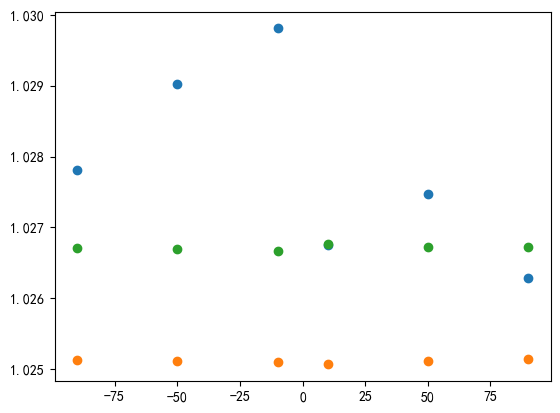

In [ ]:
df = pd.read_csv('./data_129/129#01BD/all_ave/SL_-40_ave_s.txt',sep='\\s+',header=None,skiprows=1,encoding='gb2312')

def fun_sl_average(df,gsl_list_sort,sl_list,zf_list):
    all_sl_list = []
    bd_list = [[],[],[]]
    fxxd_list = [[],[],[]]
    gname_list = []
    fzj_list = []


    axis_name_list = ['x','y','z']
    for i in sl_list:
        for j in [1,-1]:
            all_sl_list.append(i*j)
    sl_point_length = len(all_sl_list)
    # print(all_sl_list)
    df.drop(df.columns[0],axis=1,inplace=True)

    for i in range(3):
        bd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[i] ] * zf_list[i] / 3600 
        # if i==0:
        #     print(list(bd_data))
        data_x = list(bd_data)
        data_y = all_sl_list
        fits = np.polyfit(data_y,data_x,1)
        # erros = data_x - data_y*fits[0]-fits[1]
        erros = [ data_x[i] - data_y[i]*fits[0]-fits[1] for i in range(len(data_x))]
        bd_list[gsl_list_sort[i]].append(fits[0])
        fxxd_list[gsl_list_sort[i]].append( float((pd.DataFrame(erros).abs().max()/fits[0]*1e6/180).iloc[0]) )
        print()
        if i in [2,0]:
            a = -1
        else:
            a=1
        plt.scatter(pd.DataFrame(data_y),a*pd.DataFrame(data_x)/pd.DataFrame(data_y))
        print(data_y)
        print(pd.DataFrame(data_x)/pd.DataFrame(data_y))
    for i in range(3):
        for j in range(3):
            if i==j:
                continue
            t_name = axis_name_list[gsl_list_sort[i]]
            o_name = axis_name_list[gsl_list_sort[j]]
            gname = 'K{}{}'.format(o_name,t_name)
            gname_list.append(gname)
            zd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[i] ] * zf_list[i]
            cd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[j] ] * zf_list[i]
            fzj_data = (np.arcsin(cd_data/zd_data)/np.pi*180*60)[-6:].mean()
            fzj_list.append(fzj_data)

    return bd_list, fxxd_list, gname_list, fzj_list


bd_list, fxxd_list, gname_list, fzj_list = fun_sl_average(df,[2,1,0],[10,50,90],[1,1,1])
print(bd_list)
print(fxxd_list)
print(fzj_list)